# Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

import math

In [2]:
def find_IoU(list1, list2):
    # finds the IOU between two intervals, list1, list2
    list1.sort()
    list2.sort()
    min_list1 = list1[0]
    max_list1 = list1[1]
    min_list2 = list2[0]
    max_list2 = list2[1]
    intersect_list = []
    union_list = []
    if max(min_list1, min_list2) in range(min_list1, max_list1+1): 
        if max(min_list1, min_list2) in range(min_list2, max_list2+1): 
            intersect_list.extend([max(min_list1, min_list2), min(max_list1, max_list2)])
        else: 
            intersect_list.extend([0, 0])
    else: 
        intersect_list.extend([0, 0])
    union_list.extend([min(min_list1, min_list2), max(max_list1, max_list2)])
    return((intersect_list[1]-intersect_list[0])/(union_list[1]-union_list[0]))

def dataframe_IoU(df): 
    score_list = []
    for index, row in df.iterrows(): 
        score = []
        pred_peaks = df.at[index, "pred_peaks"]
        for pred_peak in pred_peaks: 
            pred_onset = pred_peak[0]
            pred_offset = pred_peak[2]
            gt_onset = df.at[index, "gt_onset"]
            gt_offset = df.at[index, "gt_offset"]
            score_list.append(find_IoU([gt_onset, gt_offset], [pred_onset, pred_offset]))
            #print(index, find_mAP([gt_onset, gt_offset], [pred_onset, pred_offset]))
    return(score_list)

def dataframe_ASR(df):
    ASR_list = []
    pred_list = 0
    for index, row in df.iterrows(): 
        pred_peaks = df.at[index, "pred_peaks"]
        for pred_peak in pred_peaks: 
            pred_list += 1
            pred_apex = pred_peak[-1]
            gt_onset = df.at[index, "gt_apexs"][0]
            gt_offset = df.at[index, "gt_apexs"][2]
            if ((gt_onset < pred_apex) and (pred_apex < gt_offset)): 
                ASR_list.append(1)
            else: 
                ASR_list.append(0)
    return(ASR_list)

def dataframe_MAE(df, j='apex'):
    MAE_list = []
    for index, row in df.iterrows(): 
        pred_peaks = df.at[index, "pred_peaks"]
        for pred_peak in pred_peaks: 
            if j == 'onset':
                pred_onset = pred_peak[0]
                gt_onset = df.at[index, "gt_apexs"][0]
                diff = abs(pred_onset - gt_onset)
            elif j == 'apex':
                pred_apex = pred_peak[-1]
                gt_apex = df.at[index, "gt_apexs"][1]
                diff = abs(pred_apex - gt_apex)
            elif j == 'offset':
                pred_offset = pred_peak[2]
                gt_offset = df.at[index, "gt_apexs"][2]
                diff = abs(pred_offset - gt_offset)
            MAE_list.append(diff)
    return(MAE_list)

def performance_metrics(df):
    IoU_list = dataframe_IoU(df)
    ASR_list = dataframe_ASR(df)
    MAE_list_apex = dataframe_MAE(df, 'apex')
    MAE_list_onset = dataframe_MAE(df, 'onset')
    MAE_list_offset = dataframe_MAE(df, 'offset')
    IoU = round(sum(IoU_list)/len(IoU_list), 3)
    ASR = round(sum(ASR_list)/len(ASR_list), 3)
    MAE_apex = round(sum(MAE_list_apex)/len(MAE_list_apex), 0)
    MAE_onset = round(sum(MAE_list_onset)/len(MAE_list_onset), 0)
    MAE_offset = round(sum(MAE_list_offset)/len(MAE_list_offset), 0)
    return(IoU, ASR, MAE_apex, MAE_onset, MAE_offset)

# Smoothing functions
def smooth(y, box_pts):
    y = [each_y[0] for each_y in y]
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    if len(y_smooth)>len(y):
        y_smooth = y_smooth[0:len(y)]
    return y_smooth

# Calculate Thresholds
def outlier_iqr(values): 
    values = np.sort(values)
    Q1, Q3 = np.quantile(values, [0.25, 0.75])
    IQR = Q3-Q1
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)
    values = values[(values > lower) & (values < upper)]
    return values

# Read and Modify csv. Files

In [3]:
ALL = pd.read_csv(r"C:\Users\Mirac\Downloads\MEAN_Spot-then-recognize-main (3)\MEAN_Spot-then-recognize-main\SMIC\score_df\spot_scoresALL.csv")

CASME2_FPS = 200
CASME_sq_FPS = 30
SMIC_E_HS_FPS = 100

subject_list = ALL['Subject'].unique().tolist()
ALL['Score_Raw'] = ALL['Score_Raw'].apply(eval).apply(np.array)
ALL['gt_peaks'] = ALL['gt_peaks'].apply(eval).apply(np.array)
ALL.rename(columns={'gt_peaks': 'gt_apexs'}, inplace=True)
ALL['gt_emotions'] = ALL['gt_emotions'].apply(eval).apply(np.array)
ALL['Video'] = ALL['Video'].apply(str)
ALL['Video'] = ALL['Video'].str.zfill(4)
ALL = ALL.sort_values(by=['Subject', 'Video'])
ALL = ALL.drop_duplicates(subset=['Subject', 'Video'], keep='first')
ALL = ALL.reset_index(drop=True)

# Calculate k_p from raw data
duration = 0 
intervals = 0
for index, row in ALL.iterrows():
    ME_interval = ALL.at[index, 'gt_apexs']
    if len(ME_interval)>1: 
        for interval in ME_interval: 
            duration += interval[2] - interval[0]
            intervals += 1
    else:
        [ME_interval] = ME_interval
        duration += ME_interval[2] - ME_interval[0]
        intervals += 1
N = duration/intervals
k_p=int((N+1)/2)
true_k_p = k_p
default_p = 0.55
print(f"k_p:{true_k_p} | default p: {default_p}")

# Adjust gt_offsets so that it does not exceed the number of spotting confidence score
count = 0
for index, row in ALL.iterrows(): 
    [ME_interval] = ALL.at[index, 'gt_apexs']
    gt_onset = ME_interval[0]
    gt_apex = ME_interval[1]
    gt_offset = ME_interval[2]
    if gt_offset >= ALL.at[index, 'Frame']: 
        count += 1
        ALL.at[index, 'gt_apexs'] = np.array([[gt_onset, gt_apex, ALL.at[index, 'Frame']-1]])
print(f"Number of gt_offsets exceed frame: {count}")  


ALL.iloc[14:22, :]

k_p:17 | default p: 0.55
Number of gt_offsets exceed frame: 0


,Subject,Video,Frame,Score_Raw,gt_apexs,gt_emotions
14,s03,ne_06,413,"[[0.06957404315471649], [0.048734162002801895]...","[[278, -1, 319]]",[negative]
15,s03,ne_07,290,"[[0.19483739137649536], [0.3969157040119171], ...","[[169, -1, 199]]",[negative]
16,s03,ne_08,419,"[[0.20940548181533813], [0.35359275341033936],...","[[229, -1, 269]]",[negative]
17,s03,ne_09,790,"[[0.035482801496982574], [0.08471453189849854]...","[[429, -1, 449]]",[negative]
18,s03,ne_10,490,"[[0.024164605885744095], [0.00664830207824707]...","[[284, -1, 314]]",[negative]
19,s03,ne_11,590,"[[0.18691599369049072], [0.8697728514671326], ...","[[331, -1, 356]]",[negative]
20,s03,ne_12,490,"[[0.08743920922279358], [0.042169928550720215]...","[[305, -1, 327]]",[negative]
21,s03,ne_13,378,"[[0.1815609335899353], [0.045041583478450775],...","[[280, -1, 310]]",[negative]


# 1: Smoothing Functions

## Model Default (1 ME per Sample)

In [4]:
# Smoothing Function 
smoothing_type = 's_MA'

iou_list = []
asr_list = []
mae_apex_list = []
mae_onset_list = []
mae_offset_list = []

k_p=34
p = 0.55
ALL_smoothed = ALL.copy()
ALL_smoothed['s_MA'] = ALL_smoothed['Score_Raw'].apply(lambda x: smooth(x, int(k_p)*2))

ALL_threshold = ALL_smoothed.copy()
ALL_threshold['modified_score'] = ALL_threshold[smoothing_type]
ALL_threshold['t_min_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() +  p* (x.max() - x.mean()))

# Finding peaks
ALL['pred_peaks']=""
for index, row in ALL.iterrows(): 
    preds=[]
    score_plot = ALL_smoothed.at[index, smoothing_type]
    
    # Assumption: 1 ME per Video Sample 
    peak = np.where(score_plot == max(score_plot))[0][0]
    
    # Assumption: Extend from apex equally, by k_p
    onset = peak-k_p
    offset = peak+k_p
    
    # To adjust for non-realistic frames
    if onset < 0: 
        onset = 0 
    if offset >= ALL_smoothed.at[index, 'Frame']: 
        offset = ALL_smoothed.at[index, 'Frame']-1
    temp = [onset, 0, offset, 0, 0, 0, peak]
    temp = [int(x) for x in temp]
    preds.append(temp) #Extend left and right side of peak by k frames
    ALL.at[index, 'pred_peaks'] = preds

# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_peaks = ALL_smoothed.copy()
ALL_peaks['pred_peaks'] = ALL['pred_peaks'].copy()
ALL_peaks = ALL_peaks.explode('gt_apexs').reset_index(inplace=False)   
ALL_peaks = ALL_peaks[['Subject', 'Video', 'Frame', 'Score_Raw', smoothing_type, 'gt_apexs', 'gt_emotions', 'pred_peaks']]
temp = pd.DataFrame(ALL_peaks["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_peaks = ALL_peaks.join(temp)
ALL_peaks["gt_onset_y"] = ""
ALL_peaks["gt_apex_y"] = ""
ALL_peaks["gt_offset_y"] = ""

# allocate separate column for each component of ME interval (onset, apex, offset)
count = 0 
for index, row in ALL_peaks.iterrows(): 
    onset = ALL_peaks.at[index, "gt_onset"]
    peak = ALL_peaks.at[index, "gt_apex"]
    offset = ALL_peaks.at[index, "gt_offset"]
    ALL_peaks.at[index, "gt_onset_y"] = ALL_peaks.at[index, smoothing_type][onset]
    ALL_peaks.at[index, "gt_apex_y"] = ALL_peaks.at[index, smoothing_type][peak]
    ALL_peaks.at[index, "gt_offset_y"] = ALL_peaks.at[index, smoothing_type][offset]

IoU, ASR, MAE_apex, MAE_onset, MAE_offset = performance_metrics(ALL_peaks)

print(f"IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")

IoU:0.289 | ASR:0.376 | MAE_apex:297.0, MAE_onset:84.0, MAE_offset:78.0


## Model Default (>= 1 ME per Sample)

## Smoothing Function: MA

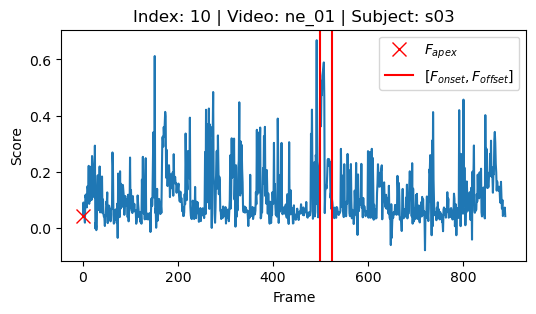

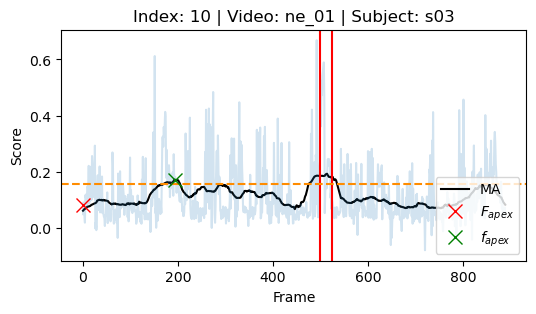

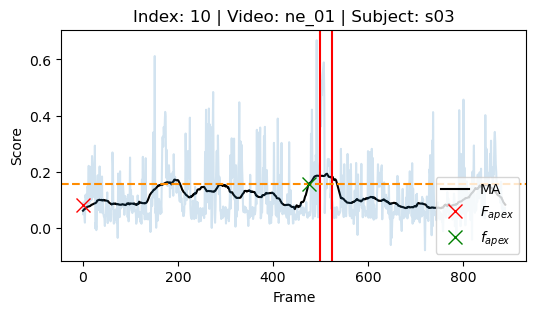

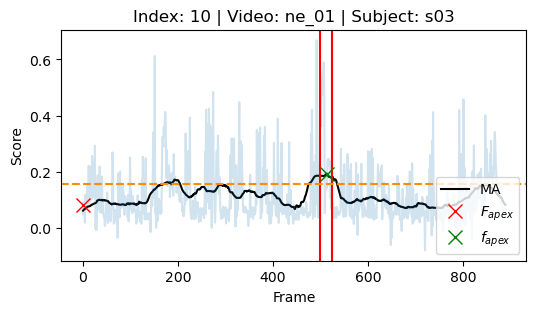

IoU:0.209 | ASR:0.247 | MAE_onset:120.0, MAE_apex:311.0, MAE_offset:114.0


In [5]:
# Smoothing Function 
smoothing_type = 's_MA'

iou_list = []
asr_list = []
mae_apex_list = []
mae_onset_list = []
mae_offset_list = []

k_p=34
p = 0.55
ALL_smoothed = ALL.copy()
ALL_smoothed['s_MA'] = ALL_smoothed['Score_Raw'].apply(lambda x: smooth(x, int(k_p)*2))

ALL_threshold = ALL_smoothed.copy()
ALL_threshold['modified_score'] = ALL_threshold[smoothing_type]
ALL_threshold['t_min_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() +  p* (x.max() - x.mean()))

# Finding peaks
ALL['pred_peaks']=""
for index, row in ALL.iterrows(): 
    preds=[]
    score_plot = ALL_smoothed.at[index, smoothing_type]
    
    # Assumption: 0 or more ME per Video Sample 
    peaks, _= find_peaks(score_plot, 
                         #prominence=0.5,
                      height=[ALL_threshold.at[index, "t_min_Moilanen"]], 
                      distance=k_p)
    if(len(peaks)==0): #Occurs when no peak is detected, simply give a value to pass the exception in mean_average_precision
        preds.append([0, 0, 0, 0, 0, 0, 0]) 
    for peak in peaks:
        # Assumption: Extend from apex equally, by k_p
        onset = peak-k_p
        offset = peak+k_p

        # To adjust for non-realistic frames
        if onset < 0: 
            onset = 0 
        if offset >= ALL_smoothed.at[index, 'Frame']: 
            offset = ALL_smoothed.at[index, 'Frame']-1
        temp = [onset, 0, offset, 0, 0, 0, peak]
        temp = [int(x) for x in temp]
        preds.append(temp) #Extend left and right side of peak by k frames
    ALL.at[index, 'pred_peaks'] = preds
    
# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_peaks = ALL_smoothed.copy()
ALL_peaks['pred_peaks'] = ALL['pred_peaks'].copy()
ALL_peaks = ALL_peaks.explode('gt_apexs').reset_index(inplace=False)   
ALL_peaks = ALL_peaks[['Subject', 'Video', 'Frame', 'Score_Raw', smoothing_type, 'gt_apexs', 'gt_emotions', 'pred_peaks']]
temp = pd.DataFrame(ALL_peaks["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_peaks = ALL_peaks.join(temp)
ALL_peaks["gt_onset_y"] = ""
ALL_peaks["gt_apex_y"] = ""
ALL_peaks["gt_offset_y"] = ""

# allocate separate column for each component of ME interval (onset, apex, offset)
count = 0 
for index, row in ALL_peaks.iterrows(): 
    onset = ALL_peaks.at[index, "gt_onset"]
    peak = ALL_peaks.at[index, "gt_apex"]
    offset = ALL_peaks.at[index, "gt_offset"]
    ALL_peaks.at[index, "gt_onset_y"] = ALL_peaks.at[index, smoothing_type][onset]
    ALL_peaks.at[index, "gt_apex_y"] = ALL_peaks.at[index, smoothing_type][peak]
    ALL_peaks.at[index, "gt_offset_y"] = ALL_peaks.at[index, smoothing_type][offset]

for index, row in ALL_peaks.iloc[10:11, :].iterrows():
    gt_onset = ALL_peaks.at[index, 'gt_onset']
    gt_apex = ALL_peaks.at[index, 'gt_apex']
    gt_offset = ALL_peaks.at[index, 'gt_offset']
    gt_onset_y_raw = ALL_peaks.at[index, 'Score_Raw'][gt_onset]
    gt_apex_y_raw = ALL_peaks.at[index, 'Score_Raw'][gt_apex]
    gt_offset_y_raw = ALL_peaks.at[index, 'Score_Raw'][gt_offset]

    plt.figure(figsize=(6, 3))
    plt.xlabel('Frame')
    plt.ylabel('Score')
    temp_vid = ALL_peaks.at[index, "Video"]
    temp_sub = ALL_peaks.at[index, "Subject"]
    plt.title(f"Index: {index} | Video: {temp_vid} | Subject: {temp_sub}")
    plt.plot(ALL_peaks.at[index, 'Score_Raw'], alpha=1)
    plt.axvline(gt_onset, color='red', alpha=1, label="$[F_{onset}, F_{offset}]$")
    plt.axvline(gt_offset, color='red', alpha=1)
    plt.legend(loc=0, frameon=True, fontsize=10)
    plt.show()
    
    peaks = ALL_peaks.at[index, "pred_peaks"]
    i = 0 
    for peak in peaks: 
        pred_onset = peak[0]
        pred_apex = peak[-1]
        pred_offset = peak[2]
        
        smoothing_type="s_MA"
        pred_onset_y = ALL_peaks.at[index, smoothing_type][pred_onset]
        pred_apex_y = ALL_peaks.at[index, smoothing_type][pred_apex]
        pred_offset_y = ALL_peaks.at[index, smoothing_type][pred_offset]
        gt_apex_y_smooth = ALL_peaks.at[index, smoothing_type][gt_apex]
        plt.figure(figsize=(6, 3))
        plt.xlabel('Frame')
        plt.ylabel('Score')
        plt.plot(ALL_peaks.at[index, smoothing_type], color='black', label="MA")
        plt.plot(ALL_peaks.at[index, 'Score_Raw'], alpha=0.2)
        plt.plot(gt_apex, gt_apex_y_smooth, marker="x", linestyle = 'None', color='red',  markersize=10,  alpha=1, label='$F_{apex}$')
        plt.axvline(gt_onset, color='red', alpha=1)
        plt.axvline(gt_offset, color='red', alpha=1)
        plt.axhline(y=ALL_threshold.at[index, "t_min_Moilanen"], color='darkorange', linestyle="--") # to plot raw threshold
        plt.plot(pred_apex, pred_apex_y, marker="x", linestyle="None", color='green', markersize=10, label='$f_{apex}$' if i == 0 else "")       
        temp_vid = ALL_peaks.at[index, "Video"]
        temp_sub = ALL_peaks.at[index, "Subject"]
        plt.title(f"Index: {index} | Video: {temp_vid} | Subject: {temp_sub}")
        plt.legend(loc="lower right", frameon=True, fontsize=10)
        plt.show()
IoU, ASR, MAE_apex, MAE_onset, MAE_offset = performance_metrics(ALL_peaks)

print(f"IoU:{IoU} | ASR:{ASR} | MAE_onset:{MAE_onset}, MAE_apex:{MAE_apex}, MAE_offset:{MAE_offset}")

## Finetuning for Smoothing Level p in MA(EXP) 

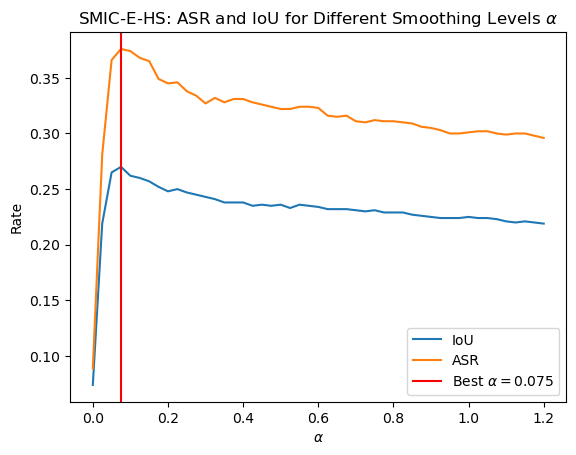

best alpha = 0.075
IoU:0.219 | ASR:0.296 | MAE_apex:318.0, MAE_onset:116.0, MAE_offset:116.0


In [24]:
# Smoothing Function 
smoothing_type = 's_MA'
k_p = true_k_p
p = default_p 

iou_list = []
asr_list = []
mae_apex_list = []
mae_onset_list = []
mae_offset_list = []

range_of_a = np.linspace(0,1.2,49)
alpha_str = '\u03B1'
    

for i in range_of_a:
    ALL_smoothed = ALL.copy()
    ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=i, optimized=False).fittedvalues.to_numpy())
    ALL_smoothed['s_MA'] = ALL_smoothed['s_Exp'].apply(lambda x: [[i] for i in x])
    ALL_smoothed['s_MA'] = ALL_smoothed['s_MA'].apply(lambda x: smooth(x, int(k_p)*2))

    ALL_threshold = ALL_smoothed.copy()
    ALL_threshold['modified_score'] = ALL_threshold[smoothing_type]
    ALL_threshold['t_min_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() + default_p * (x.max() - x.mean()))


    # Finding peaks
    ALL['pred_peaks']=""

    for index, row in ALL.iterrows(): 
        preds=[]
        score_plot = ALL_smoothed.at[index, smoothing_type]
        peaks, _= find_peaks(score_plot, 
                             #prominence=0.5,
                          height=[ALL_threshold.at[index, "t_min_Moilanen"]],# ALL_threshold.at[index, "t_max_Moilanen"]], 
                          distance=k_p)
        if(len(peaks)==0): #Occurs when no peak is detected, simply give a value to pass the exception in mean_average_precision
            preds.append([0, 0, 0, 0, 0, 0, 0]) 
        for peak in peaks:
            # Assumption: Extend from apex equally, by k_p
            onset = peak-k_p
            offset = peak+k_p

            # To adjust for non-realistic frames
            if onset < 0: 
                onset = 0 
            if offset >= ALL_smoothed.at[index, 'Frame']: 
                offset = ALL_smoothed.at[index, 'Frame']-1
            temp = [onset, 0, offset, 0, 0, 0, peak]
            temp = [int(x) for x in temp]
            preds.append(temp) #Extend left and right side of peak by k frames
        ALL.at[index, 'pred_peaks'] = preds

    # Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
    ALL_peaks = ALL_smoothed.copy()
    ALL_peaks['pred_peaks'] = ALL['pred_peaks'].copy()
    ALL_peaks = ALL_peaks.explode('gt_apexs').reset_index(inplace=False)   
    ALL_peaks = ALL_peaks[['Subject', 'Video', 'Frame', 'Score_Raw', smoothing_type, 'gt_apexs', 'gt_emotions', 'pred_peaks']]
    temp = pd.DataFrame(ALL_peaks["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
    ALL_peaks = ALL_peaks.join(temp)
    ALL_peaks["gt_onset_y"] = ""
    ALL_peaks["gt_apex_y"] = ""
    ALL_peaks["gt_offset_y"] = ""

    for index, row in ALL_peaks.iterrows(): 
        onset = ALL_peaks.at[index, "gt_onset"]
        peak = ALL_peaks.at[index, "gt_apex"]
        offset = ALL_peaks.at[index, "gt_offset"]
        ALL_peaks.at[index, "gt_onset_y"] = ALL_peaks.at[index, smoothing_type][onset]
        ALL_peaks.at[index, "gt_apex_y"] = ALL_peaks.at[index, smoothing_type][peak]
        ALL_peaks.at[index, "gt_offset_y"] = ALL_peaks.at[index, smoothing_type][offset]
    IoU, ASR, MAE_apex, MAE_onset, MAE_offset = performance_metrics(ALL_peaks)
    iou_list.append(IoU)
    asr_list.append(ASR)
    mae_apex_list.append(MAE_apex)
    mae_onset_list.append(MAE_onset)
    mae_offset_list.append(MAE_offset)
    #print(f"alpha: {i} | IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")
best_alpha = round(range_of_a[asr_list.index(max(asr_list))], 3)
plt.plot(np.linspace(0,1.2,49), iou_list,  label="IoU")
plt.xlabel('$\u03B1$')
plt.ylabel('Rate')
plt.plot(np.linspace(0,1.2,49), asr_list,  label="ASR")
plt.axvline(best_alpha, color="RED", label="Best ${\u03B1}=0.075$")
plt.legend(loc='lower right', frameon=True, fontsize=10)
plt.title("SMIC-E-HS: ASR and IoU for Different Smoothing Levels ${\u03B1}$")
plt.show()

print(f"best alpha = {best_alpha}")
print(f"IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")

## Smoothing Function: EXP

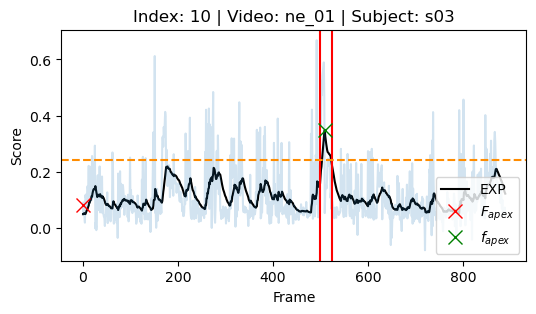

IoU:0.208 | ASR:0.313 | MAE_apex:318.0, MAE_onset:124.0, MAE_offset:124.0


In [7]:
# Specify variables
smoothing_type = 's_Exp'
k_p = true_k_p
p = default_p 
alpha = best_alpha

iou_list = []
asr_list = []
mae_apex_list = []
mae_onset_list = []
mae_offset_list = []


ALL_smoothed = ALL.copy()
ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
ALL_threshold = ALL_smoothed.copy()
ALL_threshold['modified_score'] = ALL_threshold[smoothing_type]
ALL_threshold['t_min_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() +  p* (x.max() - x.mean()))

# Finding peaks
ALL['pred_peaks']=""
for index, row in ALL.iterrows(): 
    preds=[]
    score_plot = ALL_smoothed.at[index, smoothing_type]
    
    # Assumption: 0 or more ME per Video Sample 
    peaks, _= find_peaks(score_plot, 
                         #prominence=0.5,
                      height=[ALL_threshold.at[index, "t_min_Moilanen"]], 
                      distance=k_p)
    if(len(peaks)==0): #Occurs when no peak is detected, simply give a value to pass the exception in mean_average_precision
        preds.append([0, 0, 0, 0, 0, 0, 0]) 
    for peak in peaks:
        # Assumption: Extend from apex equally, by k_p
        onset = peak-k_p
        offset = peak+k_p

        # To adjust for non-realistic frames
        if onset < 0: 
            onset = 0 
        if offset >= ALL_smoothed.at[index, 'Frame']: 
            offset = ALL_smoothed.at[index, 'Frame']-1
        temp = [onset, 0, offset, 0, 0, 0, peak]
        temp = [int(x) for x in temp]
        preds.append(temp) #Extend left and right side of peak by k frames
    ALL.at[index, 'pred_peaks'] = preds
    
# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_peaks = ALL_smoothed.copy()
ALL_peaks['pred_peaks'] = ALL['pred_peaks'].copy()
ALL_peaks = ALL_peaks.explode('gt_apexs').reset_index(inplace=False)   
ALL_peaks = ALL_peaks[['Subject', 'Video', 'Frame', 'Score_Raw', smoothing_type, 'gt_apexs', 'gt_emotions', 'pred_peaks']]
temp = pd.DataFrame(ALL_peaks["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_peaks = ALL_peaks.join(temp)
ALL_peaks["gt_onset_y"] = ""
ALL_peaks["gt_apex_y"] = ""
ALL_peaks["gt_offset_y"] = ""

# allocate separate column for each component of ME interval (onset, apex, offset)
count = 0 
for index, row in ALL_peaks.iterrows(): 
    onset = ALL_peaks.at[index, "gt_onset"]
    peak = ALL_peaks.at[index, "gt_apex"]
    offset = ALL_peaks.at[index, "gt_offset"]
    ALL_peaks.at[index, "gt_onset_y"] = ALL_peaks.at[index, smoothing_type][onset]
    ALL_peaks.at[index, "gt_apex_y"] = ALL_peaks.at[index, smoothing_type][peak]
    ALL_peaks.at[index, "gt_offset_y"] = ALL_peaks.at[index, smoothing_type][offset]
    
for index, row in ALL_peaks.iloc[10:11, :].iterrows():
    gt_onset = ALL_peaks.at[index, 'gt_onset']
    gt_apex = ALL_peaks.at[index, 'gt_apex']
    gt_offset = ALL_peaks.at[index, 'gt_offset']
    gt_onset_y_raw = ALL_peaks.at[index, 'Score_Raw'][gt_onset]
    gt_apex_y_raw = ALL_peaks.at[index, 'Score_Raw'][gt_apex]
    gt_offset_y_raw = ALL_peaks.at[index, 'Score_Raw'][gt_offset]

    peaks = ALL_peaks.at[index, "pred_peaks"]
    
    i = 0 
    plt.figure(figsize=(6, 3))
    plt.xlabel('Frame')
    plt.ylabel('Score')
    plt.plot(ALL_peaks.at[index, smoothing_type], color='black', label="EXP")
    plt.plot(ALL_peaks.at[index, 'Score_Raw'], alpha=0.2)
    plt.plot(gt_apex, gt_apex_y_smooth, marker="x", linestyle = 'None', color='red',  markersize=10,  alpha=1, label='$F_{apex}$')
    plt.axvline(gt_onset, color='red', alpha=1)
    plt.axvline(gt_offset, color='red', alpha=1)
    plt.axhline(y=ALL_threshold.at[index, "t_min_Moilanen"], color='darkorange', linestyle="--") # to plot raw threshold
    for peak in peaks: 
        pred_onset = peak[0]
        pred_apex = peak[-1]
        pred_offset = peak[2]
        smoothing_type="s_Exp"
        pred_onset_y = ALL_peaks.at[index, smoothing_type][pred_onset]
        pred_apex_y = ALL_peaks.at[index, smoothing_type][pred_apex]
        pred_offset_y = ALL_peaks.at[index, smoothing_type][pred_offset]
        plt.plot(pred_apex, pred_apex_y, marker="x", linestyle="None", color='green', markersize=10, label='$f_{apex}$' if i == 0 else "")       
        temp_vid = ALL_peaks.at[index, "Video"]
        temp_sub = ALL_peaks.at[index, "Subject"]
        plt.title(f"Index: {index} | Video: {temp_vid} | Subject: {temp_sub}")
        plt.legend(loc="lower right", frameon=True, fontsize=10)
        i += 1
    plt.show()
        
IoU, ASR, MAE_apex, MAE_onset, MAE_offset = performance_metrics(ALL_peaks)

print(f"IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")

## Smoothing Function: MA(EXP)

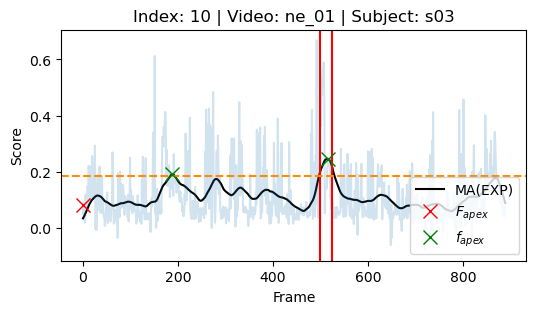

IoU:0.27 | ASR:0.376 | MAE_apex:322.0, MAE_onset:115.0, MAE_offset:116.0


In [8]:
# Specify variables
smoothing_type = 's_MA'
k_p = true_k_p
p = default_p 
alpha = best_alpha

iou_list = []
asr_list = []
mae_apex_list = []
mae_onset_list = []
mae_offset_list = []

ALL_smoothed = ALL.copy()
ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
ALL_smoothed['s_MA'] = ALL_smoothed['s_Exp'].apply(lambda x: [[i] for i in x])
ALL_smoothed['s_MA'] = ALL_smoothed['s_MA'].apply(lambda x: smooth(x, int(k_p)*2))

ALL_threshold = ALL_smoothed.copy()
ALL_threshold['modified_score'] = ALL_threshold[smoothing_type]
ALL_threshold['t_min_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() +  p * (x.max() - x.mean()))

# Finding peaks
ALL['pred_peaks']=""
for index, row in ALL.iterrows(): 
    preds=[]
    score_plot = ALL_smoothed.at[index, smoothing_type]
    
    # Assumption: 0 or more ME per Video Sample 
    peaks, _= find_peaks(score_plot, 
                         #prominence=0.5,
                      height=[ALL_threshold.at[index, "t_min_Moilanen"]], 
                      distance=k_p)
    if(len(peaks)==0): #Occurs when no peak is detected, simply give a value to pass the exception in mean_average_precision
        preds.append([0, 0, 0, 0, 0, 0, 0]) 
    for peak in peaks:
        # Assumption: Extend from apex equally, by k_p
        onset = peak-k_p
        offset = peak+k_p

        # To adjust for non-realistic frames
        if onset < 0: 
            onset = 0 
        if offset >= ALL_smoothed.at[index, 'Frame']: 
            offset = ALL_smoothed.at[index, 'Frame']-1
        temp = [onset, 0, offset, 0, 0, 0, peak]
        temp = [int(x) for x in temp]
        preds.append(temp) #Extend left and right side of peak by k frames
    ALL.at[index, 'pred_peaks'] = preds
    
# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_peaks = ALL_smoothed.copy()
ALL_peaks['pred_peaks'] = ALL['pred_peaks'].copy()
ALL_peaks = ALL_peaks.explode('gt_apexs').reset_index(inplace=False)   
ALL_peaks = ALL_peaks[['Subject', 'Video', 'Frame', 'Score_Raw', smoothing_type, 'gt_apexs', 'gt_emotions', 'pred_peaks']]
temp = pd.DataFrame(ALL_peaks["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_peaks = ALL_peaks.join(temp)
ALL_peaks["gt_onset_y"] = ""
ALL_peaks["gt_apex_y"] = ""
ALL_peaks["gt_offset_y"] = ""

# allocate separate column for each component of ME interval (onset, apex, offset)
count = 0 
for index, row in ALL_peaks.iterrows(): 
    onset = ALL_peaks.at[index, "gt_onset"]
    peak = ALL_peaks.at[index, "gt_apex"]
    offset = ALL_peaks.at[index, "gt_offset"]
    ALL_peaks.at[index, "gt_onset_y"] = ALL_peaks.at[index, smoothing_type][onset]
    ALL_peaks.at[index, "gt_apex_y"] = ALL_peaks.at[index, smoothing_type][peak]
    ALL_peaks.at[index, "gt_offset_y"] = ALL_peaks.at[index, smoothing_type][offset]

for index, row in ALL_peaks.iloc[10:11, :].iterrows():
    gt_onset = ALL_peaks.at[index, 'gt_onset']
    gt_apex = ALL_peaks.at[index, 'gt_apex']
    gt_offset = ALL_peaks.at[index, 'gt_offset']
    gt_onset_y_raw = ALL_peaks.at[index, 'Score_Raw'][gt_onset]
    gt_apex_y_raw = ALL_peaks.at[index, 'Score_Raw'][gt_apex]
    gt_offset_y_raw = ALL_peaks.at[index, 'Score_Raw'][gt_offset]

    peaks = ALL_peaks.at[index, "pred_peaks"]
    
    i = 0 
    plt.figure(figsize=(6, 3))
    plt.xlabel('Frame')
    plt.ylabel('Score')
    plt.plot(ALL_peaks.at[index, smoothing_type], color='black', label="MA(EXP)")
    plt.plot(ALL_peaks.at[index, 'Score_Raw'], alpha=0.2)
    plt.plot(gt_apex, gt_apex_y_smooth, marker="x", linestyle = 'None', color='red',  markersize=10,  alpha=1, label='$F_{apex}$')
    plt.axvline(gt_onset, color='red', alpha=1)
    plt.axvline(gt_offset, color='red', alpha=1)
    plt.axhline(y=ALL_threshold.at[index, "t_min_Moilanen"], color='darkorange', linestyle="--") # to plot raw threshold
    for peak in peaks: 
        pred_onset = peak[0]
        pred_apex = peak[-1]
        pred_offset = peak[2]
        pred_onset_y = ALL_peaks.at[index, smoothing_type][pred_onset]
        pred_apex_y = ALL_peaks.at[index, smoothing_type][pred_apex]
        pred_offset_y = ALL_peaks.at[index, smoothing_type][pred_offset]
        plt.plot(pred_apex, pred_apex_y, marker="x", linestyle="None", color='green', markersize=10, label='$f_{apex}$' if i == 0 else "")       
        temp_vid = ALL_peaks.at[index, "Video"]
        temp_sub = ALL_peaks.at[index, "Subject"]
        plt.title(f"Index: {index} | Video: {temp_vid} | Subject: {temp_sub}")
        plt.legend(loc="lower right", frameon=True, fontsize=10)
        i += 1
    plt.show()
        
IoU, ASR, MAE_apex, MAE_onset, MAE_offset = performance_metrics(ALL_peaks)

print(f"IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")

# 5.3 Threshold

## Finetuning for p in T_min

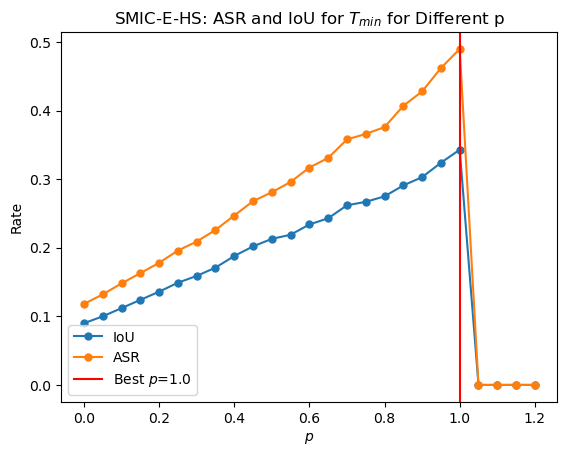

IoU:0.0 | ASR:0.0 | MAE_apex:1.0, MAE_onset:300.0, MAE_offset:333.0


In [9]:
keep_outliers = True
smoothing_type = 's_MA'
range_list = np.linspace(0,1.2,25)
k_p = true_k_p
alpha = best_alpha

iou_list = []
asr_list = []
apex_in_list = []
mae_apex_list = []
mae_onset_list = []
mae_offset_list = []
for i in range_list:
    ALL_smoothed = ALL.copy()
    if smoothing_type == 's_MA': 
        ALL_smoothed['s_MA'] = ALL_smoothed['Score_Raw'].apply(lambda x: smooth(x, int(k_p)*2))
    elif smoothing_type == 's_Exp': 
        ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
        ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
        ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
    elif smoothing_type == 's_MA(EXP)': 
        ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
        ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
        ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
        ALL_smoothed['s_MA'] = ALL_smoothed['s_Exp'].apply(lambda x: [[i] for i in x])
        ALL_smoothed['s_MA'] = ALL_smoothed['s_MA'].apply(lambda x: smooth(x, int(k_p)*2))       
        smoothing_type = 's_MA'
        
    ALL_threshold = ALL_smoothed.copy()
    if keep_outliers: 
        ALL_threshold['modified_score'] = ALL_threshold[smoothing_type]
    else: 
        ALL_threshold['modified_score'] = ALL_threshold[smoothing_type].apply(lambda x: outlier_iqr(x))
    ALL_threshold['t_min_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() + i * (x.max() - x.mean()))
    ALL_threshold['t_max_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() + i * (x.max() + x.mean()))

    ALL_threshold['t_by_sub_min_Moilanen'] = 0
    ALL_threshold['t_by_sub_max_Moilanen'] = 0
    for index, subject in enumerate(subject_list): 
        subject_sum = ALL_threshold[ALL_threshold.Subject==subject]['modified_score'].apply(lambda x:np.sum(x)).sum()
        num = ALL_threshold[ALL_threshold.Subject==subject]["Frame"].apply(lambda x:np.sum(x)).sum()
        subject_mean = subject_sum/num
        subject_max = ALL_threshold[ALL_threshold.Subject==subject][smoothing_type].apply(lambda x:np.max(x)).max()
        min_threshold = subject_mean + 0. * (subject_max - subject_mean)
        max_threshold = subject_mean + i * (subject_max + subject_mean)
        ALL_threshold.loc[ALL_threshold['Subject']==subject, 't_by_sub_min_Moilanen'] = min_threshold
        ALL_threshold.loc[ALL_threshold['Subject']==subject, 't_by_sub_max_Moilanen']  = max_threshold


    # Finding peaks
    ALL['pred_peaks']=""
    for index, row in ALL.iterrows(): 
        preds=[]
        score_plot = ALL_smoothed.at[index, smoothing_type]

        # Assumption: 1 ME per Video Sample 
        peaks, _= find_peaks(score_plot, 
                             #prominence=0.5,
                          height=[ALL_threshold.at[index, "t_min_Moilanen"]],# ALL_threshold.at[index, "t_max_Moilanen"]], 
                          distance=k_p)
        if(len(peaks)==0): #Occurs when no peak is detected, simply give a value to pass the exception in mean_average_precision
            preds.append([0, 0, 0, 0, 0, 0, 0]) 
        for peak in peaks:
            # Assumption: Extend from apex equally, by k_p
            onset = peak-k_p
            offset = peak+k_p

            # To adjust for non-realistic frames
            if onset < 0: 
                onset = 0 
            if offset >= ALL_smoothed.at[index, 'Frame']: 
                offset = ALL_smoothed.at[index, 'Frame']-1
            temp = [onset, 0, offset, 0, 0, 0, peak]
            temp = [int(x) for x in temp]
            preds.append(temp) #Extend left and right side of peak by k frames
        ALL.at[index, 'pred_peaks'] = preds

    # Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
    ALL_peaks = ALL_smoothed.copy()
    ALL_peaks['pred_peaks'] = ALL['pred_peaks'].copy()
    ALL_peaks = ALL_peaks.explode('gt_apexs').reset_index(inplace=False)   
    ALL_peaks = ALL_peaks[['Subject', 'Video', 'Frame', 'Score_Raw', smoothing_type, 'gt_apexs', 'gt_emotions', 'pred_peaks']]
    temp = pd.DataFrame(ALL_peaks["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
    ALL_peaks = ALL_peaks.join(temp)
    ALL_peaks["gt_onset_y"] = ""
    ALL_peaks["gt_apex_y"] = ""
    ALL_peaks["gt_offset_y"] = ""

    # allocate each gt_ME with emotion
    count = 0 
    ALL_peaks['gt_emotion']=''
    for index, row in ALL_peaks.iterrows(): 
        emotions = ALL_peaks.at[index, "gt_emotions"]
        if len(emotions)>1: 
            ALL_peaks.at[index, 'gt_emotion'] = str(emotions[count])
            count += 1
            if count>(len(emotions)-1): 
                count = 0 
        else: 
            ALL_peaks.at[index, 'gt_emotion'] = str(emotions[0])
        onset = ALL_peaks.at[index, "gt_onset"]
        peak = ALL_peaks.at[index, "gt_apex"]
        offset = ALL_peaks.at[index, "gt_offset"]
        ALL_peaks.at[index, "gt_onset_y"] = ALL_peaks.at[index, smoothing_type][onset]
        ALL_peaks.at[index, "gt_apex_y"] = ALL_peaks.at[index, smoothing_type][peak]
        ALL_peaks.at[index, "gt_offset_y"] = ALL_peaks.at[index, smoothing_type][offset]



    IoU, ASR, MAE_apex, MAE_onset, MAE_offset = performance_metrics(ALL_peaks)
    iou_list.append(IoU)
    asr_list.append(ASR)
    mae_apex_list.append(MAE_apex)
    mae_onset_list.append(MAE_onset)
    mae_offset_list.append(MAE_offset)
    #print(f"p:{round(i, 3)} | IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")
plt.plot(range_list, iou_list, marker="o", markersize=5,  label="IoU")
plt.xlabel('$p$')
plt.ylabel('Rate')
plt.plot(range_list, asr_list, marker="o", markersize=5,label="ASR")
plt.axvline(1.0, color="RED", label="Best $p$=1.0")
plt.legend(loc='lower left', frameon=True, fontsize=10)
plt.title("SMIC-E-HS: ASR and IoU for $T_{min}$ for Different p")
plt.show()

best_p = round(range_list[asr_list.index(max(asr_list))], 1)
print(f"best p: {best_p}")
print(f"IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")

## Finetuning for p in T_max

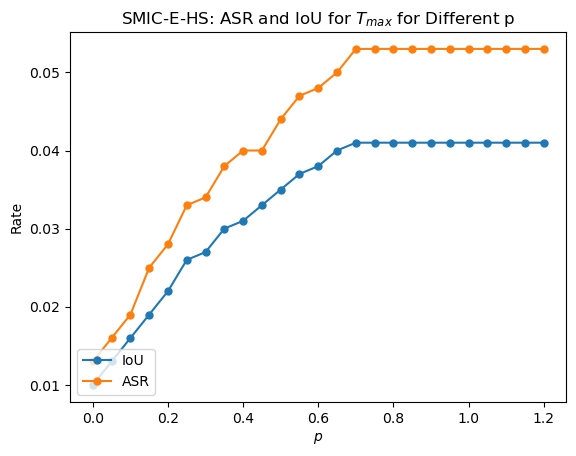

IoU:0.041 | ASR:0.053 | MAE_apex:344.0, MAE_onset:198.0, MAE_offset:198.0


In [10]:
keep_outliers = True 
smoothing_type = 's_MA'
range_list = np.linspace(0,1.2,25)
k_p = true_k_p
alpha = best_alpha

ALL_smoothed = ALL.copy()
ALL_smoothed['s_MA'] = ALL_smoothed['Score_Raw'].apply(lambda x: smooth(x, int(k_p)*2))
ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=best_alpha, optimized=False).fittedvalues.to_numpy())
# ALL_smoothed['s_MA'] = ALL_smoothed['s_Exp'].apply(lambda x: [[i] for i in x])
# ALL_smoothed['s_MA'] = ALL_smoothed['s_MA'].apply(lambda x: smooth(x, int(k_p)*2))

iou_list = []
asr_list = []
apex_in_list = []
mae_apex_list = []
mae_onset_list = []
mae_offset_list = []
for i in range_list:
    i = round(i, 3)
    ALL_threshold = ALL_smoothed.copy()
    if smoothing_type == 's_MA': 
        ALL_smoothed['s_MA'] = ALL_smoothed['Score_Raw'].apply(lambda x: smooth(x, int(k_p)*2))
    elif smoothing_type == 's_Exp': 
        ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
        ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
        ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
    elif smoothing_type == 's_MA(EXP)': 
        ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
        ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
        ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
        ALL_smoothed['s_MA'] = ALL_smoothed['s_Exp'].apply(lambda x: [[i] for i in x])
        ALL_smoothed['s_MA'] = ALL_smoothed['s_MA'].apply(lambda x: smooth(x, int(k_p)*2))       
        smoothing_type = 's_MA'
        
    ALL_threshold = ALL_smoothed.copy()
    if keep_outliers: 
        ALL_threshold['modified_score'] = ALL_threshold[smoothing_type]
    else: 
        ALL_threshold['modified_score'] = ALL_threshold[smoothing_type].apply(lambda x: outlier_iqr(x))
    ALL_threshold['t_min_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() + i * (x.max() - x.mean()))
    ALL_threshold['t_max_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() + i * (x.max() + x.mean()))

    ALL_threshold['t_by_sub_min_Moilanen'] = 0
    ALL_threshold['t_by_sub_max_Moilanen'] = 0
    for index, subject in enumerate(subject_list): 
        subject_sum = ALL_threshold[ALL_threshold.Subject==subject]['modified_score'].apply(lambda x:np.sum(x)).sum()
        num = ALL_threshold[ALL_threshold.Subject==subject]["Frame"].apply(lambda x:np.sum(x)).sum()
        subject_mean = subject_sum/num
        subject_max = ALL_threshold[ALL_threshold.Subject==subject][smoothing_type].apply(lambda x:np.max(x)).max()
        min_threshold = subject_mean + 0.1 * (subject_max - subject_mean)
        max_threshold = subject_mean + i * (subject_max + subject_mean)
        ALL_threshold.loc[ALL_threshold['Subject']==subject, 't_by_sub_min_Moilanen'] = min_threshold
        ALL_threshold.loc[ALL_threshold['Subject']==subject, 't_by_sub_max_Moilanen']  = max_threshold


    # Finding peaks
    ALL['pred_peaks']=""
    for index, row in ALL.iterrows(): 
        preds=[]
        score_plot = ALL_smoothed.at[index, smoothing_type]

        # Assumption: 1 ME per Video Sample 
        peaks, _= find_peaks(score_plot, 
                             #prominence=0.5,
                          height=[0, ALL_threshold.at[index, "t_max_Moilanen"]],# ALL_threshold.at[index, "t_max_Moilanen"]], 
                          distance=k_p)
        if(len(peaks)==0): #Occurs when no peak is detected, simply give a value to pass the exception in mean_average_precision
            preds.append([0, 0, 0, 0, 0, 0, 0]) 
        for peak in peaks:
            # Assumption: Extend from apex equally, by k_p
            onset = peak-k_p
            offset = peak+k_p

            # To adjust for non-realistic frames
            if onset < 0: 
                onset = 0 
            if offset >= ALL_smoothed.at[index, 'Frame']: 
                offset = ALL_smoothed.at[index, 'Frame']-1
            temp = [onset, 0, offset, 0, 0, 0, peak]
            temp = [int(x) for x in temp]
            preds.append(temp) #Extend left and right side of peak by k frames
        ALL.at[index, 'pred_peaks'] = preds

    # Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
    ALL_peaks = ALL_smoothed.copy()
    ALL_peaks['pred_peaks'] = ALL['pred_peaks'].copy()
    ALL_peaks = ALL_peaks.explode('gt_apexs').reset_index(inplace=False)   
    ALL_peaks = ALL_peaks[['Subject', 'Video', 'Frame', 'Score_Raw', smoothing_type, 'gt_apexs', 'gt_emotions', 'pred_peaks']]
    temp = pd.DataFrame(ALL_peaks["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
    ALL_peaks = ALL_peaks.join(temp)
    ALL_peaks["gt_onset_y"] = ""
    ALL_peaks["gt_apex_y"] = ""
    ALL_peaks["gt_offset_y"] = ""

    # allocate each gt_ME with emotion
    count = 0 
    ALL_peaks['gt_emotion']=''
    for index, row in ALL_peaks.iterrows(): 
        emotions = ALL_peaks.at[index, "gt_emotions"]
        if len(emotions)>1: 
            ALL_peaks.at[index, 'gt_emotion'] = str(emotions[count])
            count += 1
            if count>(len(emotions)-1): 
                count = 0 
        else: 
            ALL_peaks.at[index, 'gt_emotion'] = str(emotions[0])
        onset = ALL_peaks.at[index, "gt_onset"]
        peak = ALL_peaks.at[index, "gt_apex"]
        offset = ALL_peaks.at[index, "gt_offset"]
        ALL_peaks.at[index, "gt_onset_y"] = ALL_peaks.at[index, smoothing_type][onset]
        ALL_peaks.at[index, "gt_apex_y"] = ALL_peaks.at[index, smoothing_type][peak]
        ALL_peaks.at[index, "gt_offset_y"] = ALL_peaks.at[index, smoothing_type][offset]



    IoU, ASR, MAE_apex, MAE_onset, MAE_offset = performance_metrics(ALL_peaks)
    iou_list.append(IoU)
    asr_list.append(ASR)
    mae_apex_list.append(MAE_apex)
    mae_onset_list.append(MAE_onset)
    mae_offset_list.append(MAE_offset)
    #print(f"p:{round(i, 3)} | IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")
plt.plot(range_list, iou_list,marker="o", markersize=5, label="IoU")
plt.xlabel('$p$')
plt.ylabel('Rate')
plt.plot(range_list, asr_list,  marker="o", markersize=5, label="ASR")
plt.legend(loc="lower left", frameon=True, fontsize=10)
plt.title("SMIC-E-HS: ASR and IoU for $T_{max}$ for Different p")
plt.show()

print(f"IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")

## Threshold by Subject

In [11]:
keep_outliers = True 
smoothing_type = 's_MA'
range_list = np.linspace(0,1.2,25)
k_p = true_k_p
alpha = best_alpha
p = default_p 

smoothing_type = 's_MA'
ALL_smoothed = ALL.copy()
ALL_threshold = ALL_smoothed.copy()
if smoothing_type == 's_MA': 
    ALL_smoothed['s_MA'] = ALL_smoothed['Score_Raw'].apply(lambda x: smooth(x, int(k_p)*2))
elif smoothing_type == 's_Exp': 
    ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
elif smoothing_type == 's_MA(EXP)': 
    ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
    ALL_smoothed['s_MA'] = ALL_smoothed['s_Exp'].apply(lambda x: [[i] for i in x])
    ALL_smoothed['s_MA'] = ALL_smoothed['s_MA'].apply(lambda x: smooth(x, int(k_p)*2))       
    smoothing_type = 's_MA'
        
ALL_threshold = ALL_smoothed.copy()
if keep_outliers: 
    ALL_threshold['modified_score'] = ALL_threshold[smoothing_type]
else: 
    ALL_threshold['modified_score'] = ALL_threshold[smoothing_type].apply(lambda x: outlier_iqr(x))
ALL_threshold['t_min_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() + p * (x.max() - x.mean()))
ALL_threshold['t_max_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() + p * (x.max() + x.mean()))

ALL_threshold['t_by_sub_min_Moilanen'] = 0
ALL_threshold['t_by_sub_max_Moilanen'] = 0
for index, subject in enumerate(subject_list): 
    subject_sum = ALL_threshold[ALL_threshold.Subject==subject]['modified_score'].apply(lambda x:np.sum(x)).sum()
    num = ALL_threshold[ALL_threshold.Subject==subject]["Frame"].apply(lambda x:np.sum(x)).sum()
    subject_mean = subject_sum/num
    subject_max = ALL_threshold[ALL_threshold.Subject==subject][smoothing_type].apply(lambda x:np.max(x)).max()
    min_threshold = subject_mean + p * (subject_max - subject_mean)
    max_threshold = subject_mean + p * (subject_max + subject_mean)
    ALL_threshold.loc[ALL_threshold['Subject']==subject, 't_by_sub_min_Moilanen'] = min_threshold
    ALL_threshold.loc[ALL_threshold['Subject']==subject, 't_by_sub_max_Moilanen']  = max_threshold


# Finding peaks
ALL['pred_peaks']=""
for index, row in ALL.iterrows(): 
    preds=[]
    score_plot = ALL_smoothed.at[index, smoothing_type]

    # Assumption: 1 ME per Video Sample 
    peaks, _= find_peaks(score_plot, 
                         #prominence=0.5,
                      height=[0, ALL_threshold.at[index, "t_by_sub_min_Moilanen"]],# ALL_threshold.at[index, "t_max_Moilanen"]], 
                      distance=k_p)
    if(len(peaks)==0): #Occurs when no peak is detected, simply give a value to pass the exception in mean_average_precision
        preds.append([0, 0, 0, 0, 0, 0, 0]) 
    for peak in peaks:
        # Assumption: Extend from apex equally, by k_p
        onset = peak-k_p
        offset = peak+k_p

        # To adjust for non-realistic frames
        if onset < 0: 
            onset = 0 
        if offset >= ALL_smoothed.at[index, 'Frame']: 
            offset = ALL_smoothed.at[index, 'Frame']-1
        temp = [onset, 0, offset, 0, 0, 0, peak]
        temp = [int(x) for x in temp]
        preds.append(temp) #Extend left and right side of peak by k frames
    ALL.at[index, 'pred_peaks'] = preds

# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_peaks = ALL_smoothed.copy()
ALL_peaks['pred_peaks'] = ALL['pred_peaks'].copy()
ALL_peaks = ALL_peaks.explode('gt_apexs').reset_index(inplace=False)   
ALL_peaks = ALL_peaks[['Subject', 'Video', 'Frame', 'Score_Raw', smoothing_type, 'gt_apexs', 'gt_emotions', 'pred_peaks']]
temp = pd.DataFrame(ALL_peaks["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_peaks = ALL_peaks.join(temp)
ALL_peaks["gt_onset_y"] = ""
ALL_peaks["gt_apex_y"] = ""
ALL_peaks["gt_offset_y"] = ""

# allocate each gt_ME with emotion
count = 0 
ALL_peaks['gt_emotion']=''
for index, row in ALL_peaks.iterrows(): 
    emotions = ALL_peaks.at[index, "gt_emotions"]
    if len(emotions)>1: 
        ALL_peaks.at[index, 'gt_emotion'] = str(emotions[count])
        count += 1
        if count>(len(emotions)-1): 
            count = 0 
    else: 
        ALL_peaks.at[index, 'gt_emotion'] = str(emotions[0])
    onset = ALL_peaks.at[index, "gt_onset"]
    peak = ALL_peaks.at[index, "gt_apex"]
    offset = ALL_peaks.at[index, "gt_offset"]
    ALL_peaks.at[index, "gt_onset_y"] = ALL_peaks.at[index, smoothing_type][onset]
    ALL_peaks.at[index, "gt_apex_y"] = ALL_peaks.at[index, smoothing_type][peak]
    ALL_peaks.at[index, "gt_offset_y"] = ALL_peaks.at[index, smoothing_type][offset]

print(f"IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")

IoU:0.041 | ASR:0.053 | MAE_apex:344.0, MAE_onset:198.0, MAE_offset:198.0


In [12]:
keep_outliers = False
smoothing_type = 's_MA(EXP)'
p = best_p
k_p = true_k_p
alpha = best_alpha

iou_list = []
asr_list = []
apex_in_list = []
mae_apex_list = []
mae_onset_list = []
mae_offset_list = []

ALL_smoothed = ALL.copy()
if smoothing_type == 's_MA': 
    ALL_smoothed['s_MA'] = ALL_smoothed['Score_Raw'].apply(lambda x: smooth(x, int(k_p)*2))
elif smoothing_type == 's_Exp': 
    ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
elif smoothing_type == 's_MA(EXP)': 
    ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
    ALL_smoothed['s_MA'] = ALL_smoothed['s_Exp'].apply(lambda x: [[i] for i in x])
    ALL_smoothed['s_MA'] = ALL_smoothed['s_MA'].apply(lambda x: smooth(x, int(k_p)*2))       
    smoothing_type = 's_MA'

ALL_threshold = ALL_smoothed.copy()
if keep_outliers: 
    ALL_threshold['modified_score'] = ALL_threshold[smoothing_type]
else: 
    ALL_threshold['modified_score'] = ALL_threshold[smoothing_type].apply(lambda x: outlier_iqr(x))
ALL_threshold['t_min_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() + p * (x.max() - x.mean()))

# Finding peaks
ALL['pred_peaks']=""
for index, row in ALL.iterrows(): 
    preds=[]
    score_plot = ALL_smoothed.at[index, smoothing_type]

    # Assumption: 1 ME per Video Sample 
    peaks, _= find_peaks(score_plot, 
                         #prominence=0.5,
                      height=[ALL_threshold.at[index, "t_min_Moilanen"]],# ALL_threshold.at[index, "t_max_Moilanen"]], 
                      distance=k_p)
    if(len(peaks)==0): #Occurs when no peak is detected, simply give a value to pass the exception in mean_average_precision
        preds.append([0, 0, 0, 0, 0, 0, 0]) 
    for peak in peaks:
        # Assumption: Extend from apex equally, by k_p
        onset = peak-k_p
        offset = peak+k_p
        # To adjust for non-realistic frames
        if onset < 0: 
            onset = 0 
        if offset >= ALL_smoothed.at[index, 'Frame']: 
            offset = ALL_smoothed.at[index, 'Frame']-1
        temp = [onset, 0, offset, 0, 0, 0, peak]
        temp = [int(x) for x in temp]
        preds.append(temp) #Extend left and right side of peak by k frames
    ALL.at[index, 'pred_peaks'] = preds

# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_peaks = ALL_smoothed.copy()
ALL_peaks['pred_peaks'] = ALL['pred_peaks'].copy()
ALL_peaks = ALL_peaks.explode('gt_apexs').reset_index(inplace=False)   
ALL_peaks = ALL_peaks[['Subject', 'Video', 'Frame', 'Score_Raw', smoothing_type, 'gt_apexs', 'gt_emotions', 'pred_peaks']]
temp = pd.DataFrame(ALL_peaks["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_peaks = ALL_peaks.join(temp)
ALL_peaks["gt_onset_y"] = ""
ALL_peaks["gt_apex_y"] = ""
ALL_peaks["gt_offset_y"] = ""

# allocate each gt_ME with emotion
count = 0 
ALL_peaks['gt_emotion']=''
for index, row in ALL_peaks.iterrows(): 
    emotions = ALL_peaks.at[index, "gt_emotions"]
    if len(emotions)>1: 
        ALL_peaks.at[index, 'gt_emotion'] = str(emotions[count])
        count += 1
        if count>(len(emotions)-1): 
            count = 0 
    else: 
        ALL_peaks.at[index, 'gt_emotion'] = str(emotions[0])
    onset = ALL_peaks.at[index, "gt_onset"]
    peak = ALL_peaks.at[index, "gt_apex"]
    offset = ALL_peaks.at[index, "gt_offset"]
    ALL_peaks.at[index, "gt_onset_y"] = ALL_peaks.at[index, smoothing_type][onset]
    ALL_peaks.at[index, "gt_apex_y"] = ALL_peaks.at[index, smoothing_type][peak]
    ALL_peaks.at[index, "gt_offset_y"] = ALL_peaks.at[index, smoothing_type][offset]
IoU, ASR, MAE_apex, MAE_onset, MAE_offset = performance_metrics(ALL_peaks)
print(f"IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")

IoU:0.345 | ASR:0.479 | MAE_apex:332.0, MAE_onset:91.0, MAE_offset:93.0


# Apex Ratio

## Apex ratio by subject average

In [13]:
keep_outliers = True 
smoothing_type = 's_MA'
range_list = np.linspace(0,1.2,25)
k_p = true_k_p
alpha = best_alpha
p = default_p 

smoothing_type = 's_MA'
ALL_smoothed = ALL.copy()
ALL_threshold = ALL_smoothed.copy()
if smoothing_type == 's_MA': 
    ALL_smoothed['s_MA'] = ALL_smoothed['Score_Raw'].apply(lambda x: smooth(x, int(k_p)*2))
elif smoothing_type == 's_Exp': 
    ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
elif smoothing_type == 's_MA(EXP)': 
    ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
    ALL_smoothed['s_MA'] = ALL_smoothed['s_Exp'].apply(lambda x: [[i] for i in x])
    ALL_smoothed['s_MA'] = ALL_smoothed['s_MA'].apply(lambda x: smooth(x, int(k_p)*2))       
    smoothing_type = 's_MA'
        
ALL_threshold = ALL_smoothed.copy()

if keep_outliers: 
    ALL_threshold['modified_score'] = ALL_threshold[smoothing_type]
else: 
    ALL_threshold['modified_score'] = ALL_threshold[smoothing_type].apply(lambda x: outlier_iqr(x))

ALL_threshold['t_min_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() + p * (x.max() - x.mean()))


# Finding peaks
ALL['pred_peaks']=""
# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_temp = ALL_smoothed.copy()
ALL_temp = ALL_temp.explode('gt_apexs').reset_index(inplace=False)   
temp = pd.DataFrame(ALL_temp["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_temp = ALL_temp.join(temp)
ALL_temp['apex_ratio']=ALL_temp.apply(lambda x: (x.gt_apex-x.gt_onset+1)/(x.gt_offset - x.gt_onset+1), axis=1)
subject_apex_ratio = ALL_temp.groupby('Subject', as_index=False)['apex_ratio'].mean()
subject_apex_ratio = dict(subject_apex_ratio.values)
ALL_temp['subject_apex_ratio'] = ''
for index, row in ALL_smoothed.iterrows():
    ALL_temp.at[index, 'subject_apex_ratio'] = subject_apex_ratio[ALL_peaks.at[index, 'Subject']]


for index, row in ALL.iterrows(): 
    preds=[]
    score_plot = ALL_smoothed.at[index, smoothing_type]
    apex_ratio = ALL_temp.at[index, 'subject_apex_ratio']
    peaks, _= find_peaks(score_plot, 
                         #prominence=0.5,
                      height=[ALL_threshold.at[index, "t_min_Moilanen"]],# ALL_threshold.at[index, "t_max_Moilanen"]], 
                      distance=k_p)
    if(len(peaks)==0): #Occurs when no peak is detected, simply give a value to pass the exception in mean_average_precision
        preds.append([0, 0, 0, 0, 0, 0, 0]) 
    for peak in peaks:
        # Assumption: Extend from apex equally, by k_p
        onset = peak-(2*k_p*apex_ratio)
        offset = peak+(2*k_p*(1-apex_ratio))

        # To adjust for non-realistic frames
        if onset < 0: 
            onset = 0 
        if offset >= ALL_smoothed.at[index, 'Frame']: 
            offset = ALL_smoothed.at[index, 'Frame']-1
        temp = [onset, 0, offset, 0, 0, 0, peak]
        temp = [int(x) for x in temp]
        preds.append(temp) #Extend left and right side of peak by k frames
    ALL.at[index, 'pred_peaks'] = preds

# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_peaks = ALL_smoothed.copy()
ALL_peaks['pred_peaks'] = ALL['pred_peaks'].copy()
ALL_peaks = ALL_peaks.explode('gt_apexs').reset_index(inplace=False)   
ALL_peaks = ALL_peaks[['Subject', 'Video', 'Frame', 'Score_Raw', smoothing_type, 'gt_apexs', 'gt_emotions', 'pred_peaks']]
temp = pd.DataFrame(ALL_peaks["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_peaks = ALL_peaks.join(temp)
ALL_peaks["gt_onset_y"] = ""
ALL_peaks["gt_apex_y"] = ""
ALL_peaks["gt_offset_y"] = ""
# allocate each gt_ME with emotion
count = 0 
ALL_peaks['gt_emotion']=''
for index, row in ALL_peaks.iterrows(): 
    emotions = ALL_peaks.at[index, "gt_emotions"]
    if len(emotions)>1: 
        ALL_peaks.at[index, 'gt_emotion'] = str(emotions[count])
        count += 1
        if count>(len(emotions)-1): 
            count = 0 
    else: 
        ALL_peaks.at[index, 'gt_emotion'] = str(emotions[0])
    onset = ALL_peaks.at[index, "gt_onset"]
    peak = ALL_peaks.at[index, "gt_apex"]
    offset = ALL_peaks.at[index, "gt_offset"]
    ALL_peaks.at[index, "gt_onset_y"] = ALL_peaks.at[index, smoothing_type][onset]
    ALL_peaks.at[index, "gt_apex_y"] = ALL_peaks.at[index, smoothing_type][peak]
    ALL_peaks.at[index, "gt_offset_y"] = ALL_peaks.at[index, smoothing_type][offset]
IoU, ASR, MAE_apex, MAE_onset, MAE_offset = performance_metrics(ALL_peaks)

print(f"IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")

IoU:0.004 | ASR:0.296 | MAE_apex:321.0, MAE_onset:344.0, MAE_offset:209.0


## Apex ratio by dataset average

In [14]:
keep_outliers = True 
smoothing_type = 's_MA'
range_list = np.linspace(0,1.2,25)
k_p = true_k_p
alpha = best_alpha
p = default_p 

smoothing_type = 's_MA'
ALL_smoothed = ALL.copy()
ALL_threshold = ALL_smoothed.copy()
if smoothing_type == 's_MA': 
    ALL_smoothed['s_MA'] = ALL_smoothed['Score_Raw'].apply(lambda x: smooth(x, int(k_p)*2))
elif smoothing_type == 's_Exp': 
    ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
elif smoothing_type == 's_MA(EXP)': 
    ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
    ALL_smoothed['s_MA'] = ALL_smoothed['s_Exp'].apply(lambda x: [[i] for i in x])
    ALL_smoothed['s_MA'] = ALL_smoothed['s_MA'].apply(lambda x: smooth(x, int(k_p)*2))       
    smoothing_type = 's_MA'
        
ALL_threshold = ALL_smoothed.copy()

if keep_outliers: 
    ALL_threshold['modified_score'] = ALL_threshold[smoothing_type]
else: 
    ALL_threshold['modified_score'] = ALL_threshold[smoothing_type].apply(lambda x: outlier_iqr(x))

ALL_threshold['t_min_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() + p * (x.max() - x.mean()))

# Finding peaks
ALL['pred_peaks']=""
# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_temp = ALL_smoothed.copy()
ALL_temp = ALL_temp.explode('gt_apexs').reset_index(inplace=False)   
temp = pd.DataFrame(ALL_temp["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_temp = ALL_temp.join(temp)
ALL_temp['apex_ratio']=ALL_temp.apply(lambda x: (x.gt_apex-x.gt_onset+1)/(x.gt_offset - x.gt_onset+1), axis=1)
subject_apex_ratio = ALL_temp.groupby('Subject', as_index=False)['apex_ratio'].mean()
subject_apex_ratio = dict(subject_apex_ratio.values)
ALL_temp['subject_apex_ratio'] = ''
for index, row in ALL_smoothed.iterrows():
    ALL_temp.at[index, 'subject_apex_ratio'] = subject_apex_ratio[ALL_peaks.at[index, 'Subject']]


for index, row in ALL.iterrows(): 
    preds=[]
    score_plot = ALL_smoothed.at[index, smoothing_type]
    apex_ratio = 0.498
    peaks, _= find_peaks(score_plot, 
                         #prominence=0.5,
                      height=[ALL_threshold.at[index, "t_min_Moilanen"]],# ALL_threshold.at[index, "t_max_Moilanen"]], 
                      distance=k_p)
    if(len(peaks)==0): #Occurs when no peak is detected, simply give a value to pass the exception in mean_average_precision
        preds.append([0, 0, 0, 0, 0, 0, 0]) 
    for peak in peaks:
        # Assumption: Extend from apex equally, by k_p
        onset = peak-(2*k_p*apex_ratio)
        offset = peak+(2*k_p*(1-apex_ratio))

        # To adjust for non-realistic frames
        if onset < 0: 
            onset = 0 
        if offset >= ALL_smoothed.at[index, 'Frame']: 
            offset = ALL_smoothed.at[index, 'Frame']-1
        temp = [onset, 0, offset, 0, 0, 0, peak]
        temp = [int(x) for x in temp]
        preds.append(temp) #Extend left and right side of peak by k frames
    ALL.at[index, 'pred_peaks'] = preds

# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_peaks = ALL_smoothed.copy()
ALL_peaks['pred_peaks'] = ALL['pred_peaks'].copy()
ALL_peaks = ALL_peaks.explode('gt_apexs').reset_index(inplace=False)   
ALL_peaks = ALL_peaks[['Subject', 'Video', 'Frame', 'Score_Raw', smoothing_type, 'gt_apexs', 'gt_emotions', 'pred_peaks']]
temp = pd.DataFrame(ALL_peaks["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_peaks = ALL_peaks.join(temp)
ALL_peaks["gt_onset_y"] = ""
ALL_peaks["gt_apex_y"] = ""
ALL_peaks["gt_offset_y"] = ""
# allocate each gt_ME with emotion
count = 0 
ALL_peaks['gt_emotion']=''
for index, row in ALL_peaks.iterrows(): 
    emotions = ALL_peaks.at[index, "gt_emotions"]
    if len(emotions)>1: 
        ALL_peaks.at[index, 'gt_emotion'] = str(emotions[count])
        count += 1
        if count>(len(emotions)-1): 
            count = 0 
    else: 
        ALL_peaks.at[index, 'gt_emotion'] = str(emotions[0])
    onset = ALL_peaks.at[index, "gt_onset"]
    peak = ALL_peaks.at[index, "gt_apex"]
    offset = ALL_peaks.at[index, "gt_offset"]
    ALL_peaks.at[index, "gt_onset_y"] = ALL_peaks.at[index, smoothing_type][onset]
    ALL_peaks.at[index, "gt_apex_y"] = ALL_peaks.at[index, smoothing_type][peak]
    ALL_peaks.at[index, "gt_offset_y"] = ALL_peaks.at[index, smoothing_type][offset]
IoU, ASR, MAE_apex, MAE_onset, MAE_offset = performance_metrics(ALL_peaks)

print(f"IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")

IoU:0.219 | ASR:0.296 | MAE_apex:321.0, MAE_onset:115.0, MAE_offset:115.0


# Duration

## Duration by subject average

In [15]:
keep_outliers = True 
smoothing_type = 's_MA'
range_list = np.linspace(0,1.2,25)
k_p = true_k_p
alpha = best_alpha
p = default_p 
range_duration = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]
FPS=200

smoothing_type = 's_MA'
ALL_smoothed = ALL.copy()
ALL_threshold = ALL_smoothed.copy()
if smoothing_type == 's_MA': 
    ALL_smoothed['s_MA'] = ALL_smoothed['Score_Raw'].apply(lambda x: smooth(x, int(k_p)*2))
elif smoothing_type == 's_Exp': 
    ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
elif smoothing_type == 's_MA(EXP)': 
    ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
    ALL_smoothed['s_MA'] = ALL_smoothed['s_Exp'].apply(lambda x: [[i] for i in x])
    ALL_smoothed['s_MA'] = ALL_smoothed['s_MA'].apply(lambda x: smooth(x, int(k_p)*2))       
    smoothing_type = 's_MA'
        
ALL_threshold = ALL_smoothed.copy()

if keep_outliers: 
    ALL_threshold['modified_score'] = ALL_threshold[smoothing_type]
else: 
    ALL_threshold['modified_score'] = ALL_threshold[smoothing_type].apply(lambda x: outlier_iqr(x))

ALL_threshold['t_min_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() + p * (x.max() - x.mean()))


# Finding peaks
ALL['pred_peaks']=""
# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_temp = ALL_smoothed.copy()
ALL_temp = ALL_temp.explode('gt_apexs').reset_index(inplace=False)   
temp = pd.DataFrame(ALL_temp["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_temp = ALL_temp.join(temp)
ALL_temp['gt_duration']=ALL_temp.apply(lambda x: (x.gt_offset-x.gt_onset+1)/2, axis=1)
subject_duration = ALL_temp.groupby('Subject', as_index=False)['gt_duration'].mean()
subject_duration = dict(subject_duration.values)
ALL_temp['subject_duration'] = ''
for index, row in ALL_smoothed.iterrows():
    ALL_temp.at[index, 'subject_duration'] = subject_duration[ALL_peaks.at[index, 'Subject']]


for index, row in ALL.iterrows(): 
    preds=[]
    score_plot = ALL_smoothed.at[index, smoothing_type]
    k_p = ALL_temp.at[index, 'subject_duration']
    peaks, _= find_peaks(score_plot, 
                         #prominence=0.5,
                      height=[ALL_threshold.at[index, "t_min_Moilanen"]],# ALL_threshold.at[index, "t_max_Moilanen"]], 
                      distance=k_p)
    if(len(peaks)==0): #Occurs when no peak is detected, simply give a value to pass the exception in mean_average_precision
        preds.append([0, 0, 0, 0, 0, 0, 0]) 
    for peak in peaks:
        # Assumption: Extend from apex equally, by k_p
        onset = peak-k_p
        offset = peak+k_p

        # To adjust for non-realistic frames
        if onset < 0: 
            onset = 0 
        if offset >= ALL_smoothed.at[index, 'Frame']: 
            offset = ALL_smoothed.at[index, 'Frame']-1
        temp = [onset, 0, offset, 0, 0, 0, peak]
        temp = [int(x) for x in temp]
        preds.append(temp) #Extend left and right side of peak by k frames
    ALL.at[index, 'pred_peaks'] = preds


# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_peaks = ALL_smoothed.copy()
ALL_peaks['pred_peaks'] = ALL['pred_peaks'].copy()
ALL_peaks = ALL_peaks.explode('gt_apexs').reset_index(inplace=False)   
ALL_peaks = ALL_peaks[['Subject', 'Video', 'Frame', 'Score_Raw', smoothing_type, 'gt_apexs', 'gt_emotions', 'pred_peaks']]
temp = pd.DataFrame(ALL_peaks["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_peaks = ALL_peaks.join(temp)
ALL_peaks["gt_onset_y"] = ""
ALL_peaks["gt_apex_y"] = ""
ALL_peaks["gt_offset_y"] = ""
# allocate each gt_ME with emotion
count = 0 
ALL_peaks['gt_emotion']=''
for index, row in ALL_peaks.iterrows(): 
    emotions = ALL_peaks.at[index, "gt_emotions"]
    if len(emotions)>1: 
        ALL_peaks.at[index, 'gt_emotion'] = str(emotions[count])
        count += 1
        if count>(len(emotions)-1): 
            count = 0 
    else: 
        ALL_peaks.at[index, 'gt_emotion'] = str(emotions[0])
    onset = ALL_peaks.at[index, "gt_onset"]
    peak = ALL_peaks.at[index, "gt_apex"]
    offset = ALL_peaks.at[index, "gt_offset"]
    ALL_peaks.at[index, "gt_onset_y"] = ALL_peaks.at[index, smoothing_type][onset]
    ALL_peaks.at[index, "gt_apex_y"] = ALL_peaks.at[index, smoothing_type][peak]
    ALL_peaks.at[index, "gt_offset_y"] = ALL_peaks.at[index, smoothing_type][offset]
IoU, ASR, MAE_apex, MAE_onset, MAE_offset = performance_metrics(ALL_peaks)
#print(f"p:{round(i, 3)} | IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")


print(f"IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")

IoU:0.216 | ASR:0.291 | MAE_apex:320.0, MAE_onset:115.0, MAE_offset:115.0


## Fixed durations (emphasis on 0.2, 0.25 seconds)

p:0.1 | IoU:0.109 | ASR:0.353 | MAE_apex:319.0, MAE_onset:119.0, MAE_offset:119.0
p:0.2 | IoU:0.206 | ASR:0.371 | MAE_apex:320.0, MAE_onset:117.0, MAE_offset:117.0
p:0.25 | IoU:0.243 | ASR:0.375 | MAE_apex:321.0, MAE_onset:115.0, MAE_offset:115.0
p:0.3 | IoU:0.262 | ASR:0.375 | MAE_apex:321.0, MAE_onset:115.0, MAE_offset:116.0
p:0.4 | IoU:0.27 | ASR:0.377 | MAE_apex:322.0, MAE_onset:116.0, MAE_offset:117.0
p:0.5 | IoU:0.253 | ASR:0.378 | MAE_apex:322.0, MAE_onset:118.0, MAE_offset:118.0
p:0.6 | IoU:0.23 | ASR:0.381 | MAE_apex:321.0, MAE_onset:121.0, MAE_offset:120.0


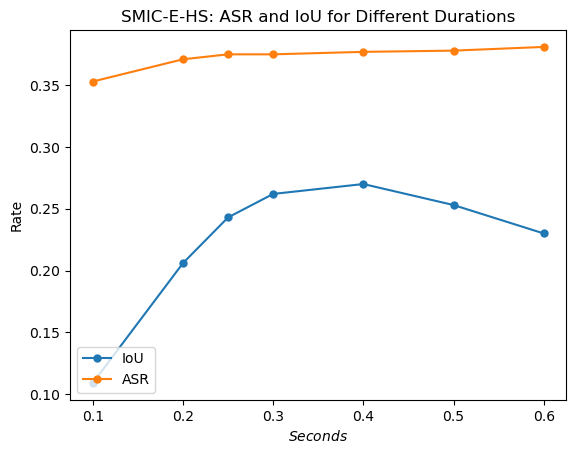

IoU:0.23 | ASR:0.381 | MAE_apex:321.0, MAE_onset:121.0, MAE_offset:120.0


In [16]:
keep_outliers = True 
smoothing_type = 's_MA(EXP)'
range_list = np.linspace(0,1.2,25)
k_p = true_k_p
alpha = best_alpha
p = default_p 
range_duration = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]
FPS=SMIC_E_HS_FPS
iou_list = []
asr_list = []
mae_apex_list = []
mae_onset_list = []
mae_offset_list = []

ALL_smoothed = ALL.copy()
if smoothing_type == 's_MA': 
    ALL_smoothed['s_MA'] = ALL_smoothed['Score_Raw'].apply(lambda x: smooth(x, int(k_p)*2))
elif smoothing_type == 's_Exp': 
    ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
elif smoothing_type == 's_MA(EXP)': 
    ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
    ALL_smoothed['s_MA'] = ALL_smoothed['s_Exp'].apply(lambda x: [[i] for i in x])
    ALL_smoothed['s_MA'] = ALL_smoothed['s_MA'].apply(lambda x: smooth(x, int(k_p)*2))       
    smoothing_type = 's_MA'
        
ALL_threshold = ALL_smoothed.copy()

if keep_outliers: 
    ALL_threshold['modified_score'] = ALL_threshold[smoothing_type]
else: 
    ALL_threshold['modified_score'] = ALL_threshold[smoothing_type].apply(lambda x: outlier_iqr(x))

ALL_threshold['t_min_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() + p * (x.max() - x.mean()))

# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_temp = ALL_smoothed.copy()
ALL_temp = ALL_temp.explode('gt_apexs').reset_index(inplace=False)   
temp = pd.DataFrame(ALL_temp["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_temp = ALL_temp.join(temp)
ALL_temp['gt_duration']=ALL_temp.apply(lambda x: (x.gt_offset-x.gt_onset+1)/2, axis=1)
subject_duration = ALL_temp.groupby('Subject', as_index=False)['gt_duration'].mean()
subject_duration = dict(subject_duration.values)
ALL_temp['subject_duration'] = ''
for index, row in ALL_smoothed.iterrows():
    ALL_temp.at[index, 'subject_duration'] = subject_duration[ALL_peaks.at[index, 'Subject']]


# Finding peaks
ALL['pred_peaks']=""
for i in range_duration:
    for index, row in ALL.iterrows(): 
        preds=[]
        score_plot = ALL_smoothed.at[index, smoothing_type]
        k_p = i*FPS*0.5
        peaks, _= find_peaks(score_plot, 
                          height=[ALL_threshold.at[index, "t_min_Moilanen"]],# ALL_threshold.at[index, "t_max_Moilanen"]], 
                          distance=k_p)
        if(len(peaks)==0): #Occurs when no peak is detected, simply give a value to pass the exception in mean_average_precision
            preds.append([0, 0, 0, 0, 0, 0, 0]) 
        for peak in peaks:
            # Assumption: Extend from apex equally, by k_p
            onset = peak-k_p
            offset = peak+k_p

            # To adjust for non-realistic frames
            if onset < 0: 
                onset = 0 
            if offset >= ALL_smoothed.at[index, 'Frame']: 
                offset = ALL_smoothed.at[index, 'Frame']-1
            temp = [onset, 0, offset, 0, 0, 0, peak]
            temp = [int(x) for x in temp]
            preds.append(temp) #Extend left and right side of peak by k frames
        ALL.at[index, 'pred_peaks'] = preds


    # Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
    ALL_peaks = ALL_smoothed.copy()
    ALL_peaks['pred_peaks'] = ALL['pred_peaks'].copy()
    ALL_peaks = ALL_peaks.explode('gt_apexs').reset_index(inplace=False)   
    ALL_peaks = ALL_peaks[['Subject', 'Video', 'Frame', 'Score_Raw', smoothing_type, 'gt_apexs', 'gt_emotions', 'pred_peaks']]
    temp = pd.DataFrame(ALL_peaks["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
    ALL_peaks = ALL_peaks.join(temp)
    ALL_peaks["gt_onset_y"] = ""
    ALL_peaks["gt_apex_y"] = ""
    ALL_peaks["gt_offset_y"] = ""

    for index, row in ALL_peaks.iterrows(): 
        onset = ALL_peaks.at[index, "gt_onset"]
        peak = ALL_peaks.at[index, "gt_apex"]
        offset = ALL_peaks.at[index, "gt_offset"]
        ALL_peaks.at[index, "gt_onset_y"] = ALL_peaks.at[index, smoothing_type][onset]
        ALL_peaks.at[index, "gt_apex_y"] = ALL_peaks.at[index, smoothing_type][peak]
        ALL_peaks.at[index, "gt_offset_y"] = ALL_peaks.at[index, smoothing_type][offset]
    IoU, ASR, MAE_apex, MAE_onset, MAE_offset = performance_metrics(ALL_peaks)
    print(f"p:{round(i, 3)} | IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")
    iou_list.append(IoU)
    asr_list.append(ASR)
    mae_apex_list.append(MAE_apex)
    mae_onset_list.append(MAE_onset)
    mae_offset_list.append(MAE_offset)
    #print(f"p:{round(i, 3)} | IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")
#plt.plot(range_duration, iou_list, marker="o", markersize=5,  label="IoU")
plt.plot(range_duration, iou_list, marker="o", markersize=5,  label="IoU")
plt.xlabel('$Seconds$')
plt.ylabel('Rate')
plt.plot(range_duration, asr_list, marker="o", markersize=5,label="ASR")
#plt.axhline(0.524, color="RED", label="Best $p$=1.0")
plt.legend(loc='lower left', frameon=True, fontsize=10)
plt.title("SMIC-E-HS: ASR and IoU for Different Durations")
plt.show()

print(f"IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")

# Final Results

In [22]:
keep_outliers = False 
smoothing_type = 's_MA(EXP)'
k_p = true_k_p
alpha = best_alpha
p = best_p 
FPS=SMIC_E_HS_FPS
iou_list = []
asr_list = []
mae_apex_list = []
mae_onset_list = []
mae_offset_list = []

ALL_smoothed = ALL.copy()
if smoothing_type == 's_MA': 
    ALL_smoothed['s_MA'] = ALL_smoothed['Score_Raw'].apply(lambda x: smooth(x, int(k_p)*2))
elif smoothing_type == 's_Exp': 
    ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
elif smoothing_type == 's_MA(EXP)': 
    ALL_smoothed['s_Exp'] = ALL_smoothed['Score_Raw'].apply(lambda x: pd.DataFrame(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: SimpleExpSmoothing(x))
    ALL_smoothed['s_Exp'] = ALL_smoothed['s_Exp'].apply(lambda x: x.fit(smoothing_level=alpha, optimized=False).fittedvalues.to_numpy())
    ALL_smoothed['s_MA'] = ALL_smoothed['s_Exp'].apply(lambda x: [[i] for i in x])
    ALL_smoothed['s_MA'] = ALL_smoothed['s_MA'].apply(lambda x: smooth(x, int(k_p)*2))       
    smoothing_type = 's_MA'
        
ALL_threshold = ALL_smoothed.copy()

if keep_outliers: 
    ALL_threshold['modified_score'] = ALL_threshold[smoothing_type]
else: 
    ALL_threshold['modified_score'] = ALL_threshold[smoothing_type].apply(lambda x: outlier_iqr(x))

ALL_threshold['t_min_Moilanen'] = ALL_threshold['modified_score'].apply(lambda x: x.mean() + p * (x.max() - x.mean()))

# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_temp = ALL_smoothed.copy()
ALL_temp = ALL_temp.explode('gt_apexs').reset_index(inplace=False)   
temp = pd.DataFrame(ALL_temp["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_temp = ALL_temp.join(temp)
ALL_temp['gt_duration']=ALL_temp.apply(lambda x: (x.gt_offset-x.gt_onset+1)/2, axis=1)
subject_duration = ALL_temp.groupby('Subject', as_index=False)['gt_duration'].mean()
subject_duration = dict(subject_duration.values)
ALL_temp['subject_duration'] = ''
for index, row in ALL_smoothed.iterrows():
    ALL_temp.at[index, 'subject_duration'] = subject_duration[ALL_peaks.at[index, 'Subject']]

# Finding peaks
ALL['pred_peaks']=""
# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_temp = ALL_smoothed.copy()
ALL_temp = ALL_temp.explode('gt_apexs').reset_index(inplace=False)   
temp = pd.DataFrame(ALL_temp["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_temp = ALL_temp.join(temp)
ALL_temp['apex_ratio']=ALL_temp.apply(lambda x: (x.gt_apex-x.gt_onset+1)/(x.gt_offset - x.gt_onset+1), axis=1)
subject_apex_ratio = ALL_temp.groupby('Subject', as_index=False)['apex_ratio'].mean()
subject_apex_ratio = dict(subject_apex_ratio.values)
ALL_temp['subject_apex_ratio'] = ''
for index, row in ALL_smoothed.iterrows():
    ALL_temp.at[index, 'subject_apex_ratio'] = subject_apex_ratio[ALL_peaks.at[index, 'Subject']]

# Finding peaks
ALL['pred_peaks']=""

for index, row in ALL.iterrows(): 
    preds=[]
    score_plot = ALL_smoothed.at[index, smoothing_type]
    apex_ratio = 0.5
    peaks, _= find_peaks(score_plot, 
                      height=[ALL_threshold.at[index, "t_min_Moilanen"]],# ALL_threshold.at[index, "t_max_Moilanen"]], 
                      distance=k_p)
    if(len(peaks)==0): #Occurs when no peak is detected, simply give a value to pass the exception in mean_average_precision
        preds.append([0, 0, 0, 0, 0, 0, 0]) 
    for peak in peaks:
        # Assumption: Extend from apex equally, by k_p
        onset = peak-(2*k_p*apex_ratio)
        offset = peak+(2*k_p*(1-apex_ratio))

        # To adjust for non-realistic frames
        if onset < 0: 
            onset = 0 
        if offset >= ALL_smoothed.at[index, 'Frame']: 
            offset = ALL_smoothed.at[index, 'Frame']-1
        temp = [onset, 0, offset, 0, 0, 0, peak]
        temp = [int(x) for x in temp]
        preds.append(temp) #Extend left and right side of peak by k frames
    ALL.at[index, 'pred_peaks'] = preds


# Create new dataframe to analyse peaks, where each row contains 1 gt ME interval
ALL_peaks = ALL_smoothed.copy()
ALL_peaks['pred_peaks'] = ALL['pred_peaks'].copy()
ALL_peaks = ALL_peaks.explode('gt_apexs').reset_index(inplace=False)   
ALL_peaks = ALL_peaks[['Subject', 'Video', 'Frame', 'Score_Raw', smoothing_type, 'gt_apexs', 'gt_emotions', 'pred_peaks']]
temp = pd.DataFrame(ALL_peaks["gt_apexs"].to_list(), columns=['gt_onset', 'gt_apex', 'gt_offset'])
ALL_peaks = ALL_peaks.join(temp)
ALL_peaks["gt_onset_y"] = ""
ALL_peaks["gt_apex_y"] = ""
ALL_peaks["gt_offset_y"] = ""

for index, row in ALL_peaks.iterrows(): 
    onset = ALL_peaks.at[index, "gt_onset"]
    peak = ALL_peaks.at[index, "gt_apex"]
    offset = ALL_peaks.at[index, "gt_offset"]
    ALL_peaks.at[index, "gt_onset_y"] = ALL_peaks.at[index, smoothing_type][onset]
    ALL_peaks.at[index, "gt_apex_y"] = ALL_peaks.at[index, smoothing_type][peak]
    ALL_peaks.at[index, "gt_offset_y"] = ALL_peaks.at[index, smoothing_type][offset]
IoU, ASR, MAE_apex, MAE_onset, MAE_offset = performance_metrics(ALL_peaks)
print(f"IoU:{IoU} | ASR:{ASR} | MAE_apex:{MAE_apex}, MAE_onset:{MAE_onset}, MAE_offset:{MAE_offset}")

IoU:0.345 | ASR:0.479 | MAE_apex:332.0, MAE_onset:91.0, MAE_offset:93.0
